In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from scipy.stats import entropy, skew
import powerlaw
from networkx.algorithms import average_clustering
from sklearn.preprocessing import MinMaxScaler

from src.dataset.dataset_info import datasets

In [2]:
my_datasets = [
    datasets["cic_ton_iot"],
    datasets["cic_ids_2017"],
    datasets["cic_bot_iot"],
    datasets["cic_ton_iot_modified"],
    datasets["ccd_inid_modified"],
    datasets["nf_uq_nids_modified"],
    datasets["edge_iiot"],
    datasets["nf_cse_cic_ids2018"],
    datasets["nf_uq_nids"],
    datasets["x_iiot"],
]

In [3]:
def plot_centrality_distribution(centrality_values, title="Centrality Distribution"):
    plt.figure(figsize=(8, 6))
    
    # Remove zero values (as log(0) is undefined)
    centrality_values = np.array(centrality_values)
    centrality_values = centrality_values[centrality_values > 0]
    
    # Define logarithmic bins
    bins = np.logspace(np.log10(min(centrality_values)), np.log10(max(centrality_values)), 20)
    
    # Compute histogram
    hist, bins = np.histogram(centrality_values, bins=bins, density=True)
    
    # Convert bins to center points for scatter plot
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    # Plot in log-log scale
    plt.scatter(bin_centers, hist, color='blue', alpha=0.7, label="Observed Data")
    
    # Set log scale
    plt.xscale('log')
    plt.yscale('log')
    
    # Labels & title
    plt.xlabel("Centrality Value")
    plt.ylabel("Probability Density P(x)")
    plt.title(title)
    plt.grid(True, which="both", linestyle="--", alpha=0.5)
    
    plt.legend()
    plt.show()


In [4]:
def check_if_scale_free(centrality_sequence):
    fit = powerlaw.Fit(centrality_sequence)
    print(f"==>> fit.alpha: {fit.alpha}")
    
    if fit.alpha > 2 and fit.alpha < 3:
        print("This graph is likely scale-free.")
    else:
        print("This graph is NOT scale-free.")

In [5]:
def check_if_small_world(G, dataset_name):
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    
    # Compute probability p to match expected edges in a random graph
    p = (2 * num_edges) / (num_nodes * (num_nodes - 1))

    # Compute metrics for input graph
    clustering = average_clustering(G)
    path_length = nx.average_shortest_path_length(G)

    # Generate a random graph with the same size (nodes and expected edges)
    random_G = nx.erdos_renyi_graph(num_nodes, p)
    
    # Compute metrics for random graph
    random_clustering = average_clustering(random_G)
    random_path_length = nx.average_shortest_path_length(random_G)

    print(f"Dataset: {dataset_name}")
    print(f"Graph Clustering Coefficient: {clustering}, Random Graph: {random_clustering}")
    print(f"Graph Avg Path Length: {path_length}, Random Graph: {random_path_length}")

    if clustering > random_clustering and path_length == random_path_length:
        print("This graph is likely a small-world network.")
    else:
        print("This graph is NOT a small-world network.")

In [6]:
def centrality_analysis(centrality_sequence, dataset_name):
    scaler = MinMaxScaler()
    normalized_values = scaler.fit_transform(centrality_sequence.reshape(-1, 1)).flatten()

    centrality_skewness = skew(normalized_values)
    print(f"Skewness: {centrality_skewness}")
    
    centrality_entropy = entropy(normalized_values + 1e-10)  # Avoid log(0) issue
    print(f"Entropy: {centrality_entropy}")
    
    check_if_scale_free(centrality_sequence)
    
    plot_centrality_distribution(centrality_sequence, f"Degree Distribution (Log-Log) of :{dataset_name}")
    

dataset: cic_ton_iot
==> degree_centrality:
Skewness: 165.84559037923003
Entropy: 3.0707012763209605
Calculating best minimal value for power law fit
==>> fit.alpha: 1.5395474796500999
This graph is NOT scale-free.


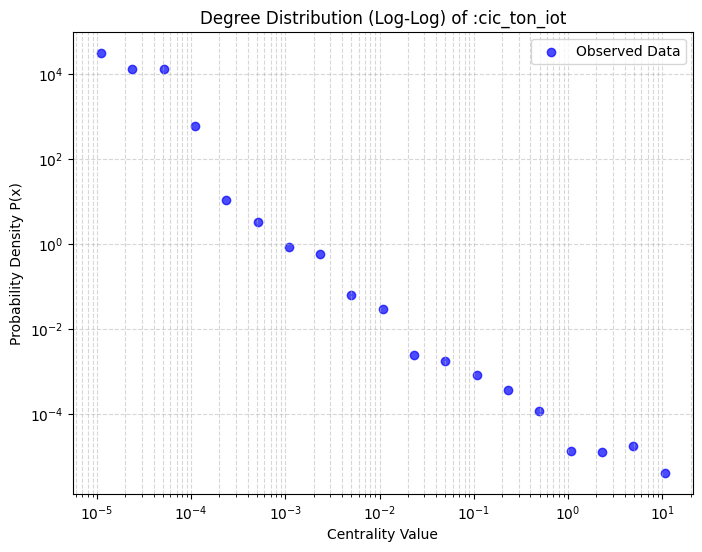

==> pagerank:
Skewness: 196.95833802169486
Entropy: 2.4282635018224497
Calculating best minimal value for power law fit
==>> fit.alpha: 1.4073992457593363
This graph is NOT scale-free.


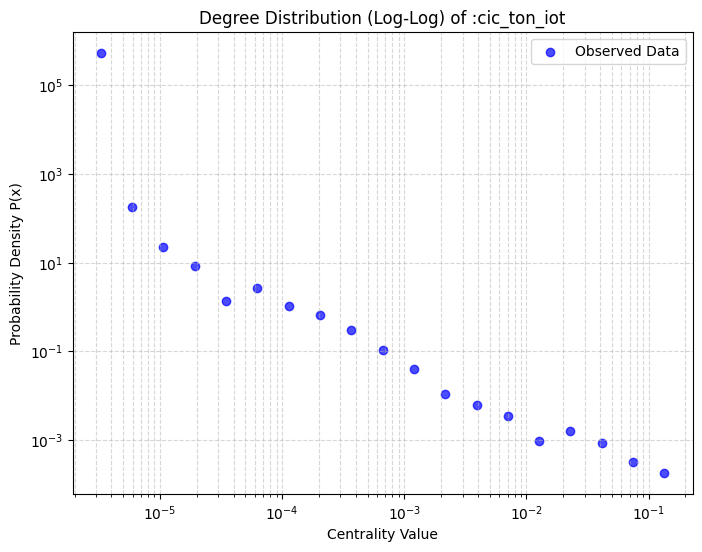

==> eigenvector:
Skewness: 166.37371953833298
Entropy: 2.3273391517934927
Calculating best minimal value for power law fit


c:\Users\Administrateur\Desktop\GNN-NIDS\.venv\Lib\site-packages\powerlaw.py:1151: RuntimeWarning: invalid value encountered in log
  self.alpha = 1 + (self.n / sum(log(data/self.xmin)))
c:\Users\Administrateur\Desktop\GNN-NIDS\.venv\Lib\site-packages\powerlaw.py:1170: RuntimeWarning: invalid value encountered in log
  return 1 + len(data)/sum(log(data / (self.xmin)))


In [7]:
for dataset in my_datasets:
    print("==========================")
    print("==========================")
    print(f"dataset: {dataset.name}")
    df = pd.read_parquet(dataset.path)
    G = nx.from_pandas_edgelist(df, dataset.src_ip_col, dataset.dst_ip_col, edge_attr=[dataset.label_col, dataset.class_num_col], create_using=nx.MultiDiGraph())
    
    
    print("==> degree_centrality:")
    degree_centrality_values = np.array(list(nx.degree_centrality(G).values()))
    centrality_analysis(degree_centrality_values, dataset.name)
    
    print("==> pagerank:")
    pagerank_values = np.array(list(nx.pagerank(G).values()))
    centrality_analysis(pagerank_values, dataset.name)
    
    print("==> eigenvector:")
    eigenvector_values = np.array(list(nx.eigenvector_centrality_numpy(G).values()))
    centrality_analysis(eigenvector_values, dataset.name)
    